# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2020-11-27 07:26:14--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  13.7MB/s    in 13s     

2020-11-27 07:26:27 (13.8 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2020-11-27 07:26:27--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  37.9MB/s    in 1.6s    

2020-11-27 07:26:29 (37.9 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2020-11-27 07:26:29--
Total wall clock time: 14s
Downloaded: 2 files, 235M in

In [ ]:
from collections import namedtuple
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

from torchvision import transforms

In [ ]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [ ]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [ ]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [ ]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    
    correct_samples = 0
    total_samples = 0
    
    for i_step, (x, y) in enumerate(loader):

        x_gpu = x.to(device)
        y_gpu = y.to(device)
        output = model(x_gpu)
        prediction = torch.argmax(output, dim=1)
        correct_samples += torch.sum(prediction == y_gpu)
        total_samples += y.shape[0]
    accuracy = float(correct_samples) / total_samples
    
    return accuracy

np.random.seed(42)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.482803, Train accuracy: 0.856039, Val accuracy: 0.835506
Average loss: 0.468662, Train accuracy: 0.860304, Val accuracy: 0.837827
Average loss: 0.450059, Train accuracy: 0.865475, Val accuracy: 0.854344
Average loss: 0.436726, Train accuracy: 0.870713, Val accuracy: 0.853184
Average loss: 0.420010, Train accuracy: 0.873972, Val accuracy: 0.856733


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [ ]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

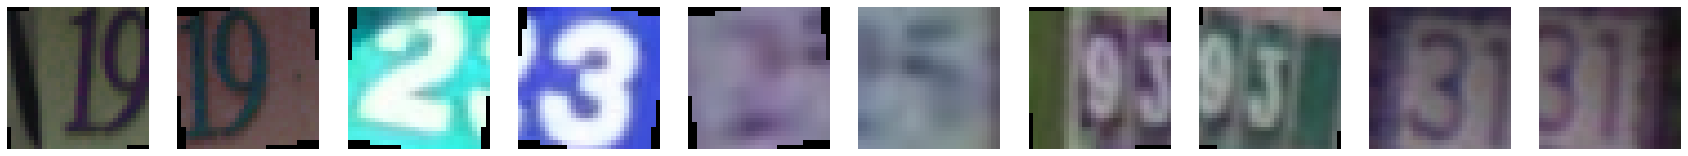

In [ ]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?
np.random.seed(42)

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [ ]:
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20]),
    #transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR)
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                               sampler=train_sampler)

In [ ]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

np.random.seed(42)
loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.555298, Train accuracy: 0.831724, Val accuracy: 0.838578
Average loss: 0.524514, Train accuracy: 0.840801, Val accuracy: 0.847109
Average loss: 0.502165, Train accuracy: 0.848309, Val accuracy: 0.850181
Average loss: 0.493700, Train accuracy: 0.852353, Val accuracy: 0.854208
Average loss: 0.475446, Train accuracy: 0.858154, Val accuracy: 0.844789


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [ ]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
            nn.Conv2d(3, 6, 5, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),    
            Flattener(),
            nn.Linear(16*5*5, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10)
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [ ]:
# Let's train it!
np.random.seed(42)
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.037707, Train accuracy: 0.670546, Val accuracy: 0.825950
Average loss: 0.616295, Train accuracy: 0.820530, Val accuracy: 0.839260
Average loss: 0.563899, Train accuracy: 0.835239, Val accuracy: 0.842195
Average loss: 0.529901, Train accuracy: 0.843190, Val accuracy: 0.815439
Average loss: 0.516814, Train accuracy: 0.849418, Val accuracy: 0.844652
Average loss: 0.499085, Train accuracy: 0.852507, Val accuracy: 0.867381
Average loss: 0.489913, Train accuracy: 0.856005, Val accuracy: 0.863286
Average loss: 0.479979, Train accuracy: 0.858257, Val accuracy: 0.869497
Average loss: 0.472493, Train accuracy: 0.860492, Val accuracy: 0.863900
Average loss: 0.469460, Train accuracy: 0.860577, Val accuracy: 0.863627


# Подбор гиперпараметров

In [ ]:
def train_model_scheduled(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
        
        if scheduler is not None:
            scheduler.step()

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

In [ ]:
np.random.seed(42)
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
anneal_coeff = 0.2
anneal_epochs = [1, 3, 5]
reg = [1e-3, 1e-4, 1e-5, 1e-7]

batch_size = 64
epoch_num = 10

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record dictionary 
# Important: perform search in logarithmic space!

# load data
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

# make datasets and loaders
data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

# apply augmentations
tfs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20]),
    #transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR)
])

data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                               sampler=train_sampler)

# perform grid search of hyperparameters
for hparam_values in product(learning_rates, anneal_epochs, reg):
    hparams = Hyperparams(*hparam_values)
    print(hparams)

    lenet_model = nn.Sequential(
            nn.Conv2d(3, 6, 5, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),    
            Flattener(),
            nn.Linear(16*5*5, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10)
          )

    lenet_model.type(torch.cuda.FloatTensor)
    lenet_model.to(device)

    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.SGD(lenet_model.parameters(), lr=hparams.learning_rate, weight_decay=hparams.reg)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=hparams.anneal_epochs, gamma=anneal_coeff, last_epoch=-1, verbose=False)
    loss_history, train_history, val_history = train_model_scheduled(lenet_model, train_aug_loader, val_loader, loss, optimizer, scheduler, epoch_num)

    final_val_accuracy = compute_accuracy(lenet_model, val_loader)
    result = RunResult(lenet_model, train_history, val_history, final_val_accuracy)

    run_record[hparams] = result

Hyperparams(learning_rate=0.1, anneal_epochs=1, reg=0.001)
Average loss: 1.186463, Train accuracy: 0.613708, Val accuracy: 0.801037
Average loss: 0.561801, Train accuracy: 0.841279, Val accuracy: 0.855505
Average loss: 0.515351, Train accuracy: 0.855305, Val accuracy: 0.861989
Average loss: 0.505309, Train accuracy: 0.858086, Val accuracy: 0.864037
Average loss: 0.505341, Train accuracy: 0.858581, Val accuracy: 0.863695
Average loss: 0.503367, Train accuracy: 0.858615, Val accuracy: 0.863149
Average loss: 0.503583, Train accuracy: 0.857967, Val accuracy: 0.863149
Average loss: 0.505986, Train accuracy: 0.857404, Val accuracy: 0.863149
Average loss: 0.504194, Train accuracy: 0.858752, Val accuracy: 0.863149
Average loss: 0.503297, Train accuracy: 0.858854, Val accuracy: 0.863149
Hyperparams(learning_rate=0.1, anneal_epochs=1, reg=0.0001)
Average loss: 1.161477, Train accuracy: 0.623008, Val accuracy: 0.805201
Average loss: 0.573142, Train accuracy: 0.837662, Val accuracy: 0.855436
Avera

KeyboardInterrupt: ignored

In [ ]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.88, best hyperparams: Hyperparams(learning_rate=0.1, anneal_epochs=5, reg=0.001)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [ ]:
Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

In [ ]:
np.random.seed(42)
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

anneal_coeff = 0.2

batch_size = 64


# load data
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

# make datasets and loaders
data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SequentialSampler(data_test)

val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size,
                                         sampler=test_sampler)


# apply augmentations
tfs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20]),
    #transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR)
])

data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                               sampler=train_sampler)

In [ ]:
np.random.seed(42)
hparams = Hyperparams(learning_rate=3e-2, anneal_epochs=5, reg=3e-2)
print(hparams)

epoch_num = 30

lenet_model = nn.Sequential(
    nn.Conv2d(3, 20, 5, padding=0),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(20),
    nn.MaxPool2d(2),
    nn.Conv2d(20, 60, 5, padding=0),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(60),
    nn.MaxPool2d(2),    
    Flattener(),
    nn.Linear(60*5*5, 120),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(120),
    nn.Linear(120, 84),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(84),
    nn.Linear(84, 10)
)

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=hparams.learning_rate, weight_decay=hparams.reg)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=hparams.anneal_epochs, gamma=anneal_coeff, last_epoch=-1, verbose=False)
loss_history, train_history, val_history = train_model_scheduled(lenet_model, train_aug_loader, val_loader, loss, optimizer, scheduler, epoch_num)

final_val_accuracy = compute_accuracy(lenet_model, val_loader)
result = RunResult(lenet_model, train_history, val_history, final_val_accuracy)

run_record[hparams] = result

Hyperparams(learning_rate=0.03, anneal_epochs=5, reg=0.03)
Average loss: 0.729693, Train accuracy: 0.788093, Val accuracy: 0.881305
Average loss: 0.521150, Train accuracy: 0.863461, Val accuracy: 0.876868
Average loss: 0.505606, Train accuracy: 0.870184, Val accuracy: 0.872910
Average loss: 0.497392, Train accuracy: 0.875286, Val accuracy: 0.848952
Average loss: 0.491036, Train accuracy: 0.877129, Val accuracy: 0.864924
Average loss: 0.374425, Train accuracy: 0.916749, Val accuracy: 0.923964
Average loss: 0.341683, Train accuracy: 0.927533, Val accuracy: 0.923623
Average loss: 0.330598, Train accuracy: 0.931270, Val accuracy: 0.919664
Average loss: 0.328523, Train accuracy: 0.932447, Val accuracy: 0.920756
Average loss: 0.324056, Train accuracy: 0.932533, Val accuracy: 0.918299
Average loss: 0.269695, Train accuracy: 0.952821, Val accuracy: 0.934339
Average loss: 0.253320, Train accuracy: 0.958946, Val accuracy: 0.936114
Average loss: 0.245122, Train accuracy: 0.961898, Val accuracy: 0

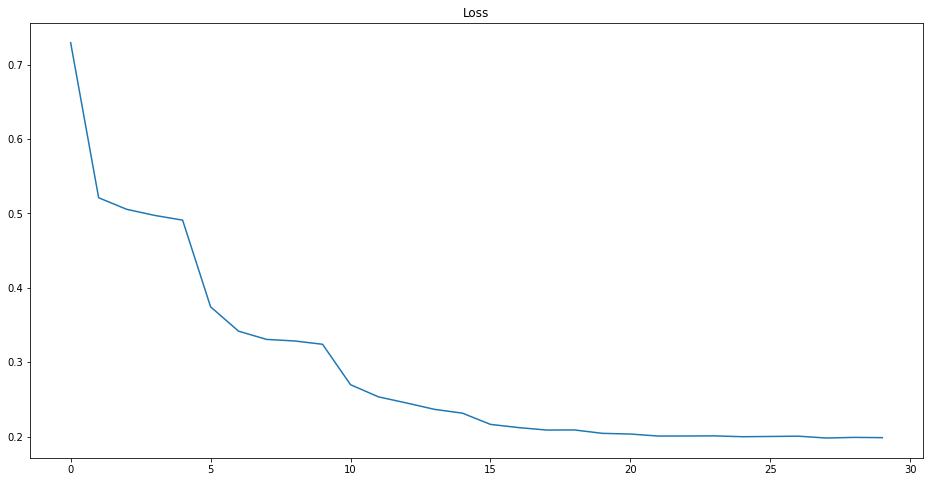

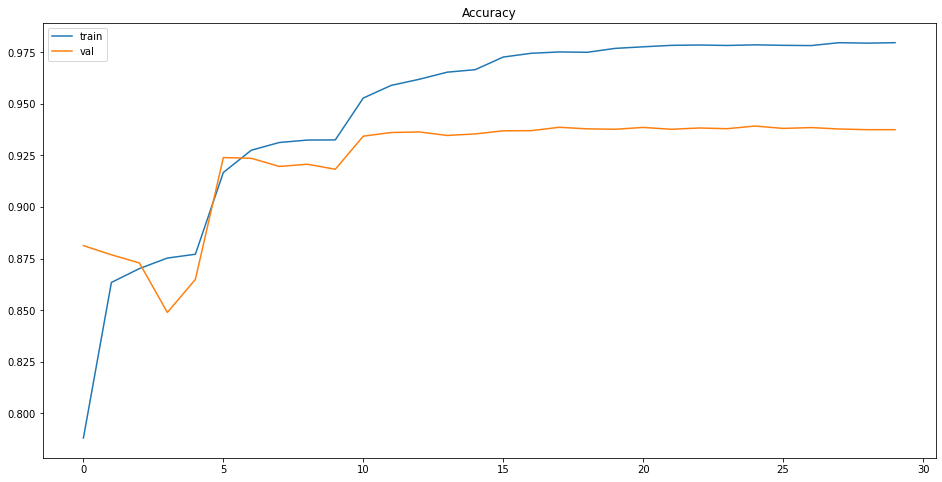

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(loss_history)
plt.title('Loss')
plt.show()

plt.figure(figsize=(16, 8))
plt.plot(result.train_history)
plt.plot(result.val_history)
plt.legend(['train', 'val'])
plt.title('Accuracy')
plt.show()

In [ ]:
best_model = lenet_model
best_result = result
best_hparams = hparams

In [ ]:
best_result.final_val_accuracy

0.9374786703979251

In [ ]:
best_hparams

Hyperparams(learning_rate=0.03, anneal_epochs=5, reg=0.03)

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [ ]:
# TODO Write the code to compute accuracy on test set
final_test_accuracy = compute_accuracy(lenet_model, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.936040258143823
